# Notebook 1

#### This notebook contains the preliminary scraping of our basic layoff dataset and a series of analysis and visualization based on different metrics.

In [1]:
import requests
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import re
import time
import os

from tqdm import tqdm

## Company Info Scraping
\
In this section, we scraped the company layoff info and store it in a json file.

In [2]:
url = "https://airtable.com/v0.3/view/viwA14Z1pM69YIsaW/readSharedViewData?stringifiedObjectParams=%7B%22shouldUseNestedResponseFormat%22%3Atrue%7D&requestId=req9aJfPtn90c2PUB&accessPolicy=%7B%22allowedActions%22%3A%5B%7B%22modelClassName%22%3A%22view%22%2C%22modelIdSelector%22%3A%22viwA14Z1pM69YIsaW%22%2C%22action%22%3A%22readSharedViewData%22%7D%2C%7B%22modelClassName%22%3A%22view%22%2C%22modelIdSelector%22%3A%22viwA14Z1pM69YIsaW%22%2C%22action%22%3A%22getMetadataForPrinting%22%7D%2C%7B%22modelClassName%22%3A%22view%22%2C%22modelIdSelector%22%3A%22viwA14Z1pM69YIsaW%22%2C%22action%22%3A%22readSignedAttachmentUrls%22%7D%2C%7B%22modelClassName%22%3A%22row%22%2C%22modelIdSelector%22%3A%22rows%20*%5BdisplayedInView%3DviwA14Z1pM69YIsaW%5D%22%2C%22action%22%3A%22createDocumentPreviewSession%22%7D%5D%2C%22shareId%22%3A%22shrqYt5kSqMzHV9R5%22%2C%22applicationId%22%3A%22app1PaujS9zxVGUZ4%22%2C%22generationNumber%22%3A0%2C%22expires%22%3A%222025-03-27T00%3A00%3A00.000Z%22%2C%22signature%22%3A%22934f344bac5c9bcc8ee9fa3d93910b9c0a37b5b91b20c275f0dea6ae18dfb838%22%7D"

In [3]:
headers = {
    "authority": "airtable.com",
    "method": "GET",
    "scheme": "https",
    "accept": "*/*",
    "accept-encoding": "gzip, deflate, br, zstd",
    "accept-language": "en,zh-CN;q=0.9,zh;q=0.8",
    "cache-control": "no-cache",
    "pragma": "no-cache",
    "priority": "u=1, i",
    "sec-ch-ua": '"Not(A:Brand";v="99", "Google Chrome";v="133", "Chromium";v="133")',
    "sec-ch-ua-mobile": "?0",
    "sec-ch-ua-platform": '"macOS"',
    "sec-fetch-dest": "empty",
    "sec-fetch-mode": "cors",
    "sec-fetch-site": "same-origin",
    "sec-fetch-storage-access": "active",
    "traceparent": "00-60862f8885984ff435ad0da12515212a-a912cb2b1f710aa7-01",
    "tracestate": "",
    "user-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/133.0.0.0 Safari/537.36",
    "x-airtable-accept-msgpack": "true",
    "x-airtable-application-id": "app1PaujS9zxVGUZ4",
    "x-airtable-inter-service-client": "webClient",
    "x-airtable-page-load-id": "pglp894en5DcI26Vl",
    "x-early-prefetch": "true",
    "x-requested-with": "XMLHttpRequest",
    "x-time-zone": "America/Los_Angeles",
    "x-user-locale": "en",
    "cookie": "brw=brwhNruLDDkLvgwxC; __Host-airtable-session=eyJzZXNzaW9uSWQiOiJzZXNYQUF1RU9hWUtzRldUMCIsImNzcmZTZWNyZXQiOiJjODBZdWstdXpPTWJ2YUxSQVZ3WVdiRUcifQ==; __Host-airtable-session.sig=7eWz3xJBHoskHwuFkvCCB36jlPH1jTZGeIJhfHdat-4; brwConsent=opt-in; AWSALBTGCORS=3YfL1WFR3vNd3EiHejd5YTAQIairwoFQ4td4LY7quXGCYo7BEd+s+u8X/f9W9GgyqIUglj2gX8O7Pp7NTydwcVM628OTlkbsrW0ICJBHn1W2pz4K9ET9VmNMpxPrLFsIvuS8gbs2e8U4TFR/ylsBkrOm1sCL1hf8Wm2UbiF8C8Bect97a4w="
}

response = requests.get(url, headers=headers)

if response.status_code == 200:
    print("Request successful!")
else:
    print("Request failed with status code:", response.status_code)

Request successful!


In [4]:
data = response.json()

#### First, we should scrape and store the key-value pairs of the attribute name with the options.

In [5]:
column_mapping = {col['id']: col['name'] for col in data['data']['table']['columns']}
column_mapping

{'fldWyUNuYW5ObN8Fw': 'Company',
 'fld1mbRJlknicV1Dk': 'Location HQ',
 'flduZSpdFqkB4eeEh': '# Laid Off',
 'fldXPv4gHmcbxvQRi': 'Date',
 'fldMPQjXwImpjkDqb': '%',
 'fldMvtAoxHCri39uZ': 'Industry',
 'fldcrmTO88VxOYeSX': 'Source',
 'fldbWCltYdMzywX2v': 'Stage',
 'fld5Rl99rerd8qYDZ': '$ Raised (mm)',
 'fldnR6AcR7HjRtwrG': 'Country',
 'fldjEGNXkyOJSP4ZM': 'Date Added'}

In [6]:
choice_mapping = {}
for col in data['data']['table']['columns']:
    type_options = col.get("typeOptions", {})  # 取 typeOptions，默认空字典
    if type_options and "choices" in type_options:
        choice_mapping.update({k: v["name"] for k, v in type_options["choices"].items()})

#### Then, we want to use the key-value pairs to translate the form json data and store the data in json file.

In [7]:
data['data']['table']['rows'][1]

{'id': 'rec5LNb6KAjxxlwHf',
 'createdTime': '2025-03-07T15:44:34.000Z',
 'cellValuesByColumnId': {'fldWyUNuYW5ObN8Fw': 'Hewlett Packard Enterprise',
  'fld1mbRJlknicV1Dk': ['selKhBn9WkXIaFjXW'],
  'fldMvtAoxHCri39uZ': 'sel1MYDovcsOJmhve',
  'flduZSpdFqkB4eeEh': 2500,
  'fldMPQjXwImpjkDqb': 0.05,
  'fldXPv4gHmcbxvQRi': '2025-03-06T00:00:00.000Z',
  'fldcrmTO88VxOYeSX': 'https://www.cnbc.com/2025/03/06/hewlett-packard-enterprise-hpe-q1-earnings-report-2025.html',
  'fld5Rl99rerd8qYDZ': 1400,
  'fldbWCltYdMzywX2v': 'sela5OuwQcXOkl5WO',
  'fldjEGNXkyOJSP4ZM': '2025-03-07T15:44:34.000Z',
  'fldnR6AcR7HjRtwrG': 'seldVNXmT64IJdbP2'}}

In [8]:
parsed_rows = []
for row in data['data']['table']['rows']:
    parsed_row = {"id": row["id"], "createdTime": row["createdTime"]} 

    for col_id, value in row["cellValuesByColumnId"].items():
        col_name = column_mapping.get(col_id, col_id)  

        if isinstance(value, list):
            parsed_row[col_name] = [choice_mapping.get(v, v) for v in value]
        else:
            parsed_row[col_name] = choice_mapping.get(value, value)  

    parsed_rows.append(parsed_row)

In [9]:
parsed_rows[0]

{'id': 'rec2tqf8OmiZh9Wvt',
 'createdTime': '2025-03-07T15:40:08.000Z',
 'Company': 'Wayfair ',
 'Location HQ': ['Boston'],
 'Industry': 'Retail',
 '# Laid Off': 340,
 'Date': '2025-03-07T00:00:00.000Z',
 'Source': 'https://finance.yahoo.com/news/retailer-wayfair-restructures-technology-team-135556649.html',
 '$ Raised (mm)': 1700,
 'Stage': 'Post-IPO',
 'Date Added': '2025-03-07T15:40:08.000Z',
 'Country': 'Germany'}

In [10]:
file_path = "parsed_data.json"

if not os.path.exists(file_path):
    with open(file_path, "w", encoding="utf-8") as f:
        json.dump(parsed_rows, f, indent=4, ensure_ascii=False)
    print(f"File {file_path} created.")
else:
    print(f"File {file_path} already exists. Skipping write operation.")

File parsed_data.json already exists. Skipping write operation.


## Preliminary Analysis
\
In this section, we analyzed the layoff information in different metrics and visualized the trend.

In [11]:
file_path = "parsed_data.json"

with open(file_path, "r", encoding="utf-8") as f:
    parsed_data = json.load(f)

In [12]:
for entry in parsed_data:
    location = entry.get("Location HQ", [])

    if isinstance(location, list) and len(location) > 0:
        entry["Location HQ"] = location[0]
    else:
        entry["Location HQ"] = None

In [13]:
parsed_data[2]

{'id': 'recr94xcTouPNRRqJ',
 'createdTime': '2025-02-28T01:59:29.000Z',
 'Company': 'Autodesk',
 'Location HQ': 'SF Bay Area',
 'Industry': 'Other',
 '# Laid Off': 1350,
 '%': 0.09,
 'Date': '2025-02-27T00:00:00.000Z',
 'Source': 'https://www.cnbc.com/2025/02/27/autodesk-says-it-will-cut-1350-employees.html',
 'Stage': 'Post-IPO',
 'Date Added': '2025-02-28T01:59:29.000Z',
 'Country': 'United States'}

In [14]:
df = pd.DataFrame(parsed_data)
df.head(5)

,id,createdTime,Company,Location HQ,Industry,# Laid Off,Date,Source,Stage,Date Added,Country,%,$ Raised (mm)
0,recitkJubTy3py2wl,2025-03-01T00:00:40.000Z,HP,SF Bay Area,Hardware,2000.0,2025-02-28T00:00:00.000Z,https://www.sfchronicle.com/tech/article/hp-jo...,Post-IPO,2025-03-01T00:00:40.000Z,United States,NaN,NaN
1,recskFMSsCMd2LSaW,2025-03-01T00:05:23.000Z,Grubhub,SF Bay Area,Food,500.0,2025-02-28T00:00:00.000Z,https://www.reuters.com/technology/food-delive...,Acquired,2025-03-01T00:05:23.000Z,United States,0.23,284.0
2,recr94xcTouPNRRqJ,2025-02-28T01:59:29.000Z,Autodesk,SF Bay Area,Other,1350.0,2025-02-27T00:00:00.000Z,https://www.cnbc.com/2025/02/27/autodesk-says-...,Post-IPO,2025-02-28T01:59:29.000Z,United States,0.09,NaN
3,reczkA3PhNk5vSuRr,2025-02-28T04:41:13.000Z,Google,SF Bay Area,Consumer,NaN,2025-02-27T00:00:00.000Z,https://www.cnbc.com/2025/02/27/google-makes-c...,Post-IPO,2025-02-28T04:41:13.000Z,United States,NaN,26.0
4,recvqXOTKFiQo16YZ,2025-03-01T00:06:04.000Z,Flywire,Boston,Finance,125.0,2025-02-26T00:00:00.000Z,https://www.bostonglobe.com/2025/02/26/busines...,Series E,2025-03-01T00:06:04.000Z,United States,NaN,263.0


In [15]:
columns_to_drop = ["id", "createdTime", "Source", "Date Added", "$ Raised (mm)"]
df = df.drop(columns=columns_to_drop)
df.head(3)

,Company,Location HQ,Industry,# Laid Off,Date,Stage,Country,%
0,HP,SF Bay Area,Hardware,2000.0,2025-02-28T00:00:00.000Z,Post-IPO,United States,NaN
1,Grubhub,SF Bay Area,Food,500.0,2025-02-28T00:00:00.000Z,Acquired,United States,0.23
2,Autodesk,SF Bay Area,Other,1350.0,2025-02-27T00:00:00.000Z,Post-IPO,United States,0.09


In [16]:
df['# Laid Off'] = df['# Laid Off'].fillna(0).astype(int)
df["Date"] = pd.to_datetime(df["Date"])
df["Date"] = df["Date"].dt.strftime("%Y-%m-%d")
df.head(5)

,Company,Location HQ,Industry,# Laid Off,Date,Stage,Country,%
0,HP,SF Bay Area,Hardware,2000,2025-02-28,Post-IPO,United States,NaN
1,Grubhub,SF Bay Area,Food,500,2025-02-28,Acquired,United States,0.23
2,Autodesk,SF Bay Area,Other,1350,2025-02-27,Post-IPO,United States,0.09
3,Google,SF Bay Area,Consumer,0,2025-02-27,Post-IPO,United States,NaN
4,Flywire,Boston,Finance,125,2025-02-26,Series E,United States,NaN


In [17]:
df = df[df["Date"] >= "2022-03-01"]
df

,Company,Location HQ,Industry,# Laid Off,Date,Stage,Country,%
0,HP,SF Bay Area,Hardware,2000,2025-02-28,Post-IPO,United States,NaN
1,Grubhub,SF Bay Area,Food,500,2025-02-28,Acquired,United States,0.23
2,Autodesk,SF Bay Area,Other,1350,2025-02-27,Post-IPO,United States,0.09
3,Google,SF Bay Area,Consumer,0,2025-02-27,Post-IPO,United States,NaN
4,Flywire,Boston,Finance,125,2025-02-26,Series E,United States,NaN
...,...,...,...,...,...,...,...,...
3298,Better.com,New York City,Real Estate,3000,2022-03-08,Unknown,United States,0.33
3299,Adaptive Biotechnologies,Seattle,Healthcare,100,2022-03-08,Post-IPO,United States,0.12
3300,Hyperscience,New York City,Data,100,2022-03-03,Series E,United States,0.25
3301,WeDoctor,Non-U.S.,Healthcare,500,2022-03-02,Series F,China,NaN


So far we've already had the data.

### Layoff visualization on a timeline from March 2022 to Feb 2025

In [18]:
df_timeline = df.copy()

In [19]:
df_timeline["Date"] = df_timeline["Date"].astype(str)
df_timeline["Date"] = pd.to_datetime(df_timeline["Date"], errors='coerce')
df_timeline["Year-Month"] = df_timeline["Date"].dt.to_period("M")
df_timeline["# Laid Off"] = df_timeline["# Laid Off"].fillna(0).astype(int)
df_timeline.head(5)

,Company,Location HQ,Industry,# Laid Off,Date,Stage,Country,%,Year-Month
0,HP,SF Bay Area,Hardware,2000,2025-02-28,Post-IPO,United States,NaN,2025-02
1,Grubhub,SF Bay Area,Food,500,2025-02-28,Acquired,United States,0.23,2025-02
2,Autodesk,SF Bay Area,Other,1350,2025-02-27,Post-IPO,United States,0.09,2025-02
3,Google,SF Bay Area,Consumer,0,2025-02-27,Post-IPO,United States,NaN,2025-02
4,Flywire,Boston,Finance,125,2025-02-26,Series E,United States,NaN,2025-02


In [20]:
monthly_layoffs = df_timeline.groupby("Year-Month")["# Laid Off"].sum()

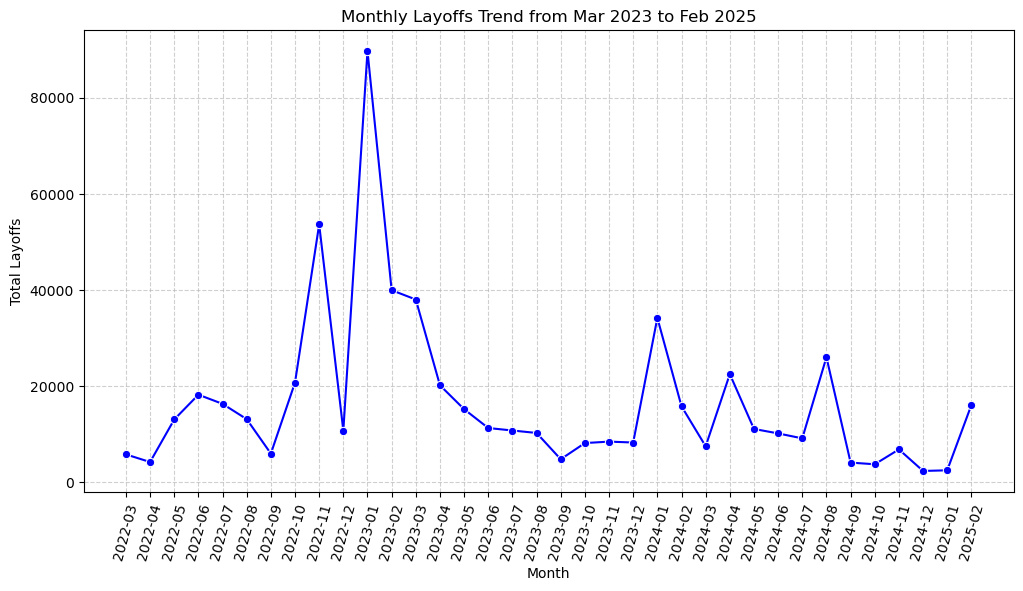

In [21]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_layoffs.index.astype(str), y=monthly_layoffs.values, marker="o", linestyle="-", color="b")

plt.xticks(rotation=75)
plt.xlabel("Month")
plt.ylabel("Total Layoffs")
plt.title("Monthly Layoffs Trend from Mar 2023 to Feb 2025")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


We can see the highest layoff happened on December 2022, and after keeping a relatively low rate during 2023, the rate went high again at the end of 2023. 
\
 **(The NaN data regarded as 0)**

### Layoff visualization by company from March 2022 to Feb 2025
\
Now we are interested in which companies have conducted most layoffs by times and by number of employees.

In [22]:
df.head(5)

,Company,Location HQ,Industry,# Laid Off,Date,Stage,Country,%
0,HP,SF Bay Area,Hardware,2000,2025-02-28,Post-IPO,United States,NaN
1,Grubhub,SF Bay Area,Food,500,2025-02-28,Acquired,United States,0.23
2,Autodesk,SF Bay Area,Other,1350,2025-02-27,Post-IPO,United States,0.09
3,Google,SF Bay Area,Consumer,0,2025-02-27,Post-IPO,United States,NaN
4,Flywire,Boston,Finance,125,2025-02-26,Series E,United States,NaN


In [23]:
company_layoffs = df.groupby('Company')['# Laid Off'].sum().reset_index()
top_companies = company_layoffs.sort_values(by='# Laid Off', ascending=False).reset_index(drop=True)
top_companies

,Company,# Laid Off
0,Amazon,27840
1,Meta,24600
2,Intel,16115
3,Microsoft,14708
4,Tesla,14500
...,...,...
2316,LiveVox,0
2317,LiveRamp,0
2318,Liongard,0
2319,LingoAce,0


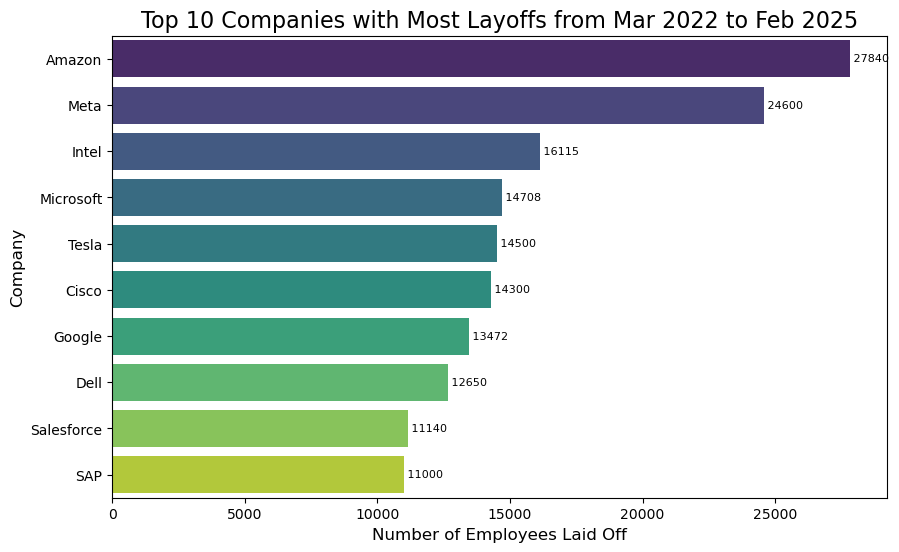

In [24]:
top_10_companies = top_companies.head(10)

plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    x='# Laid Off', 
    y='Company', 
    data=top_10_companies, 
    hue="Company", 
    palette='viridis', 
    legend=False 
)

plt.title('Top 10 Companies with Most Layoffs from Mar 2022 to Feb 2025', fontsize=16)
plt.xlabel('Number of Employees Laid Off', fontsize=12)
plt.ylabel('Company', fontsize=12)

for index, value in enumerate(top_10_companies['# Laid Off']):
    barplot.text(value, index, f' {value}', va='center', fontsize=8)

plt.show()

In [25]:
company_layoff_counts = df["Company"].value_counts().reset_index()
company_layoff_counts.columns = ["Company", "Layoff Count"]

company_layoff_counts.head(10)


,Company,Layoff Count
0,Google,13
1,Amazon,13
2,Microsoft,11
3,Unity,7
4,Salesforce,7
5,Spotify,7
6,Rivian,7
7,Expedia,7
8,Intel,7
9,Jellysmack,6


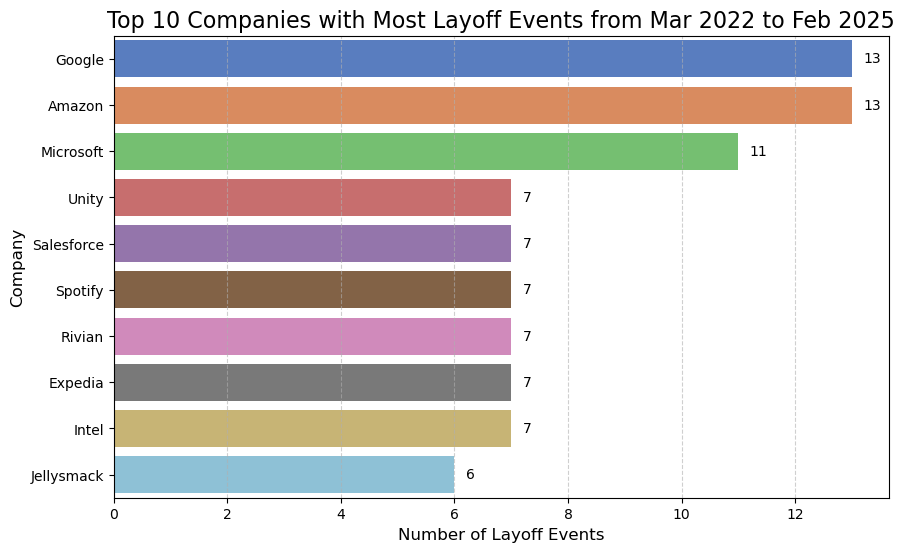

In [26]:
top_10_layoff_counts = company_layoff_counts.head(10)

plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    x="Layoff Count", 
    y="Company",
    data=top_10_layoff_counts, 
    hue="Company", 
    palette='muted', 
    legend=False 
)

plt.title("Top 10 Companies with Most Layoff Events from Mar 2022 to Feb 2025", fontsize=16)
plt.xlabel("Number of Layoff Events", fontsize=12)
plt.ylabel("Company", fontsize=12)

for index, value in enumerate(top_10_layoff_counts["Layoff Count"]):
    plt.text(value + 0.2, index, str(value), va="center", fontsize=10)

plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()


### Layoff visualization by industries from March 2022 to Feb 2025

In [27]:
industry_layoffs = df.groupby("Industry")["# Laid Off"].sum().reset_index()
industry_layoffs = industry_layoffs.sort_values(by="# Laid Off", ascending=False).reset_index(drop=True)

industry_layoffs.head(10)

,Industry,# Laid Off
0,Consumer,65253
1,Retail,63941
2,Other,62883
3,Hardware,56928
4,Transportation,47351
5,Finance,42038
6,Food,39889
7,Healthcare,37436
8,Infrastructure,20077
9,Education,17333


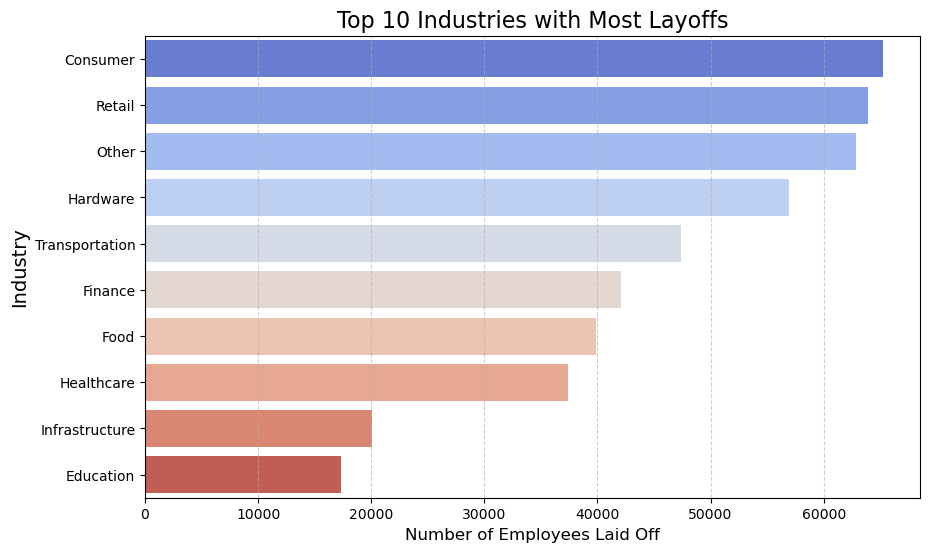

In [28]:
top_10_industries = industry_layoffs.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x="# Laid Off", y="Industry", data=top_10_industries, hue="Industry", palette="coolwarm")

plt.title("Top 10 Industries with Most Layoffs", fontsize=16)
plt.xlabel("Number of Employees Laid Off", fontsize=12)
plt.ylabel("Industry", fontsize=14)

# for index, value in enumerate(top_10_industries["# Laid Off"]):
#     plt.text(value + 500, index, str(value), va="center", fontsize=10)

plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()

In [29]:
df_stage_summary = df[df["# Laid Off"] > 0]

df_stage_summary = df_stage_summary.groupby("Stage").agg(
    record_count=("Company", "count"),
    total_laid_off=("# Laid Off", "sum"),
    avg_laid_off=("# Laid Off", "mean")
).reset_index()

In [30]:
df_stage_summary["avg_laid_off"] = df_stage_summary["avg_laid_off"].astype(int)
df_stage_summary

,Stage,record_count,total_laid_off,avg_laid_off
0,Acquired,199,51640,259
1,Post-IPO,572,362164,633
2,Private Equity,32,9135,285
3,Seed,30,1946,64
4,Series A,110,6623,60
5,Series B,203,23876,117
6,Series C,208,22549,108
7,Series D,168,16648,99
8,Series E,114,19278,169
9,Series F,65,9610,147


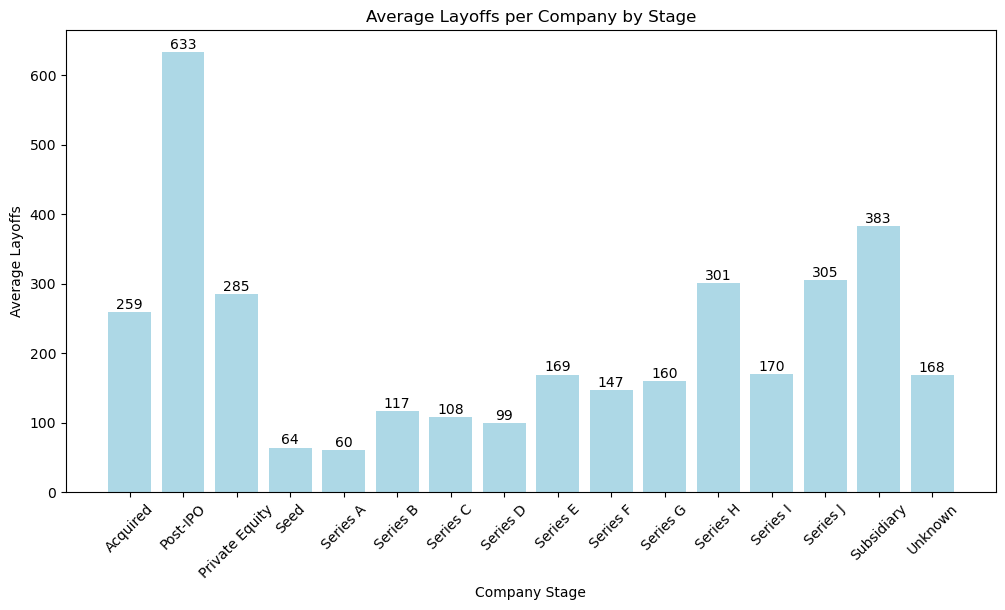

In [31]:
plt.figure(figsize=(12, 6))

plt.bar(df_stage_summary["Stage"], df_stage_summary["avg_laid_off"], color='lightblue')

for i, val in enumerate(df_stage_summary["avg_laid_off"]):
    plt.text(i, val + 5, str(val), ha='center', fontsize=10)

plt.xlabel("Company Stage")
plt.ylabel("Average Layoffs")
plt.title("Average Layoffs per Company by Stage", loc='center')  # 关键参数 loc='center'
plt.xticks(rotation=45)

plt.show()

## Geo Visualization

In [32]:
df

,Company,Location HQ,Industry,# Laid Off,Date,Stage,Country,%
0,HP,SF Bay Area,Hardware,2000,2025-02-28,Post-IPO,United States,NaN
1,Grubhub,SF Bay Area,Food,500,2025-02-28,Acquired,United States,0.23
2,Autodesk,SF Bay Area,Other,1350,2025-02-27,Post-IPO,United States,0.09
3,Google,SF Bay Area,Consumer,0,2025-02-27,Post-IPO,United States,NaN
4,Flywire,Boston,Finance,125,2025-02-26,Series E,United States,NaN
...,...,...,...,...,...,...,...,...
3298,Better.com,New York City,Real Estate,3000,2022-03-08,Unknown,United States,0.33
3299,Adaptive Biotechnologies,Seattle,Healthcare,100,2022-03-08,Post-IPO,United States,0.12
3300,Hyperscience,New York City,Data,100,2022-03-03,Series E,United States,0.25
3301,WeDoctor,Non-U.S.,Healthcare,500,2022-03-02,Series F,China,NaN


In [33]:
def get_geo_location(city, country):
    base_url = "https://nominatim.openstreetmap.org/search"
    params = {
        "city": city,
        "country": country,
        "format": "json",
        "limit": 1
    }
    response = requests.get(base_url, params=params, headers={"User-Agent": "Mozilla/5.0"})
    if response.status_code == 200:
        data = response.json()
        if data:
            return data[0]['lat'], data[0]['lon']

    return None, None

In [34]:
def find_locations_with_geo(df, location_corrections):

    df_new = df.copy()

    df_new["Latitude"] = None
    df_new["Longitude"] = None

    for index, row in tqdm(df_new.iterrows(), total=len(df_new), desc="Processing Locations", unit="entry"):
        city = row["Location HQ"]
        country = row["Country"]

        if pd.isna(city) or pd.isna(country):
            continue
        
        # filter out records without mentioning city
        if "Non-U.S." in city:
            continue

        location_key = f"{city}, {country}"
        if location_key in location_corrections:
            city, country = location_corrections[location_key]

        lat, lon = get_geo_location(city, country)
        df_new.at[index, "Latitude"] = lat
        df_new.at[index, "Longitude"] = lon
        
        time.sleep(0.5)

    return df_new

In [35]:
location_corrections = {
    "SF Bay Area, United States": ("San Francisco", "United States"),
    "New York City, France": ("New York City", "United States"),
    "Tel Aviv, United States": ("Tel Aviv", "Israel"),
    "SF Bay Area, Ireland": ("San Francisco", "United States"),
    "Jakarta, India": ("Jakarta", "Indonesia"),
    "Shenzen, China": ("Shenzhen", "China"),
    "Hong Kong, Hong Kong": ("Hong Kong", "China"),
    "Gydnia, Poland": ("Gdynia", "Poland"),
    "Mexico City, United States": ("Mexico City", "Mexico"),
    "Beijing, United States": ("Beijing", "China"),
    "Dubai, United States": ("Dubai", "United Arab Emirates"),
    "Eindhoven, United States": ("Eindhoven", "Netherlands"),
    "Oslo, Sweden": ("Oslo", "Norway"),
    "Ferdericton, Canada": ("Fredericton", "Canada"),
    "SF Bay Area, Israel": ("San Francisco", "United States"),
    "Selangor, United States": ("Selangor", "Malaysia"),
    "Sao Paulo, United States": ("Sao Paulo", "Brazil"),
}

In [36]:
csv_filename = "layoff_data_with_geo.csv"

if os.path.exists(csv_filename):
    print(f"File {csv_filename} existed, loading data...")
    df_loc = pd.read_csv(csv_filename)
else:
    print("File not found, get geo data...")
    df_loc = find_locations_with_geo(df, location_corrections)
    df_loc.to_csv(csv_filename, index=False)

File layoff_data_with_geo.csv existed, loading data...


In [37]:
df_loc.head(10)

,Company,Location HQ,Industry,# Laid Off,Date,Stage,Country,%,Latitude,Longitude
0,HP,SF Bay Area,Hardware,2000,2025-02-28,Post-IPO,United States,NaN,37.779259,-122.419329
1,Grubhub,SF Bay Area,Food,500,2025-02-28,Acquired,United States,0.23,37.779259,-122.419329
2,Autodesk,SF Bay Area,Other,1350,2025-02-27,Post-IPO,United States,0.09,37.779259,-122.419329
3,Google,SF Bay Area,Consumer,0,2025-02-27,Post-IPO,United States,NaN,37.779259,-122.419329
4,Flywire,Boston,Finance,125,2025-02-26,Series E,United States,NaN,42.355433,-71.060511
5,eBay,Tel Aviv,Retail,20,2025-02-26,Post-IPO,Israel,NaN,32.085300,34.781806
6,Commercetools,Munich,Retail,0,2025-02-26,Series C,Germany,0.10,48.137108,11.575382
7,Dayforce,Toronto,HR,0,2025-02-26,Post-IPO,United States,0.05,41.904858,-90.864035
8,Expedia,Seattle,Travel,0,2025-02-26,Post-IPO,United States,NaN,47.603832,-122.330062
9,Skybox Security,SF Bay Area,Security,300,2025-02-24,Private Equity,United States,1.00,37.779259,-122.419329


In [38]:
df_loc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3303 entries, 0 to 3302
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Company      3303 non-null   object 
 1   Location HQ  3302 non-null   object 
 2   Industry     3302 non-null   object 
 3   # Laid Off   3303 non-null   int64  
 4   Date         3303 non-null   object 
 5   Stage        3296 non-null   object 
 6   Country      3303 non-null   object 
 7   %            2101 non-null   float64
 8   Latitude     3299 non-null   float64
 9   Longitude    3299 non-null   float64
dtypes: float64(3), int64(1), object(6)
memory usage: 258.2+ KB


In [39]:
fig = px.scatter_map(
    df_loc,
    lat="Latitude",
    lon="Longitude",
    hover_name="Company", 
    zoom=0.8, 
    map_style="open-street-map"
)

fig.update_layout(
    width=1000,
    height=600
)


fig.show()

In [40]:
fig.write_html("../results/layoffs_map.html")

In [41]:
df_by_city = df_loc.groupby("Location HQ").agg({"# Laid Off": "sum", "Latitude": "first", "Longitude": "first"}).reset_index()
df_by_city.head(5)

,Location HQ,# Laid Off,Latitude,Longitude
0,Abuja,0,9.064331,7.489297
1,Accra,150,5.557110,-0.201238
2,Alamosa,0,37.470185,-105.862466
3,Albany,371,42.651167,-73.754968
4,Amsterdam,14145,52.373080,4.892453


In [42]:
df_by_city = df_by_city[df_by_city["# Laid Off"] > 0]
df_by_city = df_by_city.sort_values(by="# Laid Off", ascending=False).reset_index(drop=True)

In [43]:
df_by_city

,Location HQ,# Laid Off,Latitude,Longitude
0,SF Bay Area,193410,37.779259,-122.419329
1,Seattle,53172,47.603832,-122.330062
2,Austin,32585,30.271129,-97.743700
3,New York City,30133,40.712728,-74.006015
4,Bengaluru,24802,12.988157,77.622600
...,...,...,...,...
180,Nashik,19,20.011247,73.790236
181,Chattanooga,16,35.045722,-85.309488
182,Gydnia,13,54.523330,18.604028
183,Santa Fe,8,35.687610,-105.938456


In [44]:
from sklearn.preprocessing import MinMaxScaler

# to make SF city bubble not too big
max_cutoff = 60000
df_by_city["# Laid Off"] = df_by_city["# Laid Off"].clip(upper=max_cutoff)

scaler = MinMaxScaler(feature_range=(5, 40))

fig = go.Figure()

fig.add_trace(go.Scattergeo(
    lon=df_by_city['Longitude'],
    lat=df_by_city['Latitude'],
    text=df_by_city["Location HQ"] + '<br>Laid Off: ' + df_by_city["# Laid Off"].astype(str),
    marker=dict(
        size=scaler.fit_transform(df_by_city[["# Laid Off"]]),
        color=df_by_city["# Laid Off"],
        colorscale="YlOrRd",
        showscale=True,
        line_color='black',
        line_width=0.5,
        colorbar=dict(
            tickvals=[0, 10000, 20000, 30000, 40000, 50000, 60000],  # 数值刻度
            ticktext=["0", "10k", "20k", "30k", "40k", "50k", ">60k"]  # 修改最大值为 ">80k"
        ),
    )
))

fig.update_layout(
    geo=dict(
        scope='world',
        showland=True, 
        landcolor="rgb(230, 220, 220)",  # land color
        showcoastlines=True,
        coastlinecolor="black", 
        showcountries=True,      # country borders
        countrycolor="gray",
        projection_type="natural earth"  # 更自然的地球投影
    ),
    width=1000,
    height=600 
)

fig.show()


In [45]:
fig.write_html("../results/layoffs_scales_bubblemap.html")